Обучить модель классификации рукописных цифр на Tensorflow.


In [1]:
import tensorflow as tf
print(tf.__version__)
from google.colab import drive
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np


2.6.0


####Вспомогательный код

In [2]:
#@title 
def show_mnist(images, labels, predicted_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {labels[i]}. Pred: {predicted_labels[i]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {labels[i]}")

def show_progress(history: dict):
    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(1,2,1)    
    plt.plot(history["accuracy"],label='train accuracy')
    plt.plot(history["val_accuracy"], label='test accuracy')
    ax2 = plt.subplot(1,2,2)
    plt.plot(history["loss"],label='train_loss')
    plt.plot(history["val_loss"],label='test_loss')
    
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    plt.grid()
    plt.tight_layout()
    plt.show()

## Загрузка данных

11501568/11490434 [==============================] - 0s 0us/step


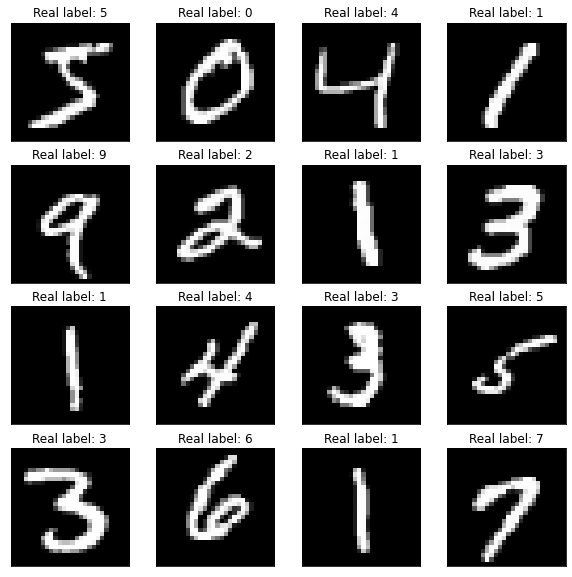

In [3]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

show_mnist(x_train, y_train)
x_train = x_train.reshape((-1, 28*28)) # вытянули каждую картинку в вектор
x_test = x_test.reshape((-1, 28*28))


# Требования к модели:
1. Точность на тестовой части выборки >96%
2. Чекпоинт модели с лучшими параметрами должен быть сохранен у вас на гугл диске
3. Объект history, который получается из model.fit(...) должен содержать значения лосса и accuracy для трейна и теста

In [8]:
path = Path("model_2")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.hdf5"
cpt_path =str(path / cpt_filename)


model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

model.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=15, batch_size=128, verbose=0, 
                    callbacks=[checkpoint])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________

Epoch 00001: val_accuracy improved from -inf to 0.96080, saving model to model_2/checkpoint_best.hdf5

Epoch 00002: val_accuracy improved from 0.96080 to 0.97110, saving model to model_2/checkpoint_best.hdf5

Epoch 00003: val_accuracy improved from 0.97110 to 0.97440, saving model to model_2/checkpoint_best.hdf5

Epoch 00004: val_accuracy improved from 0.97440 to 0.98030, sa

In [9]:
assert len(list(path.glob("*"))) != 0, f"Checkpoint dir {path}"
assert "accuracy" in history.history, "History object must contain Accuracy. Please, retrain with this metric"
assert "val_accuracy" in history.history, "Please, provide validation_data in model.fit."
assert np.max(history.history["val_accuracy"]) > 0.95, "Validation accuracy must be more than 0.95"
print("Training tests passed")

Training tests passed


Давайте посмотрим на графики обучения:

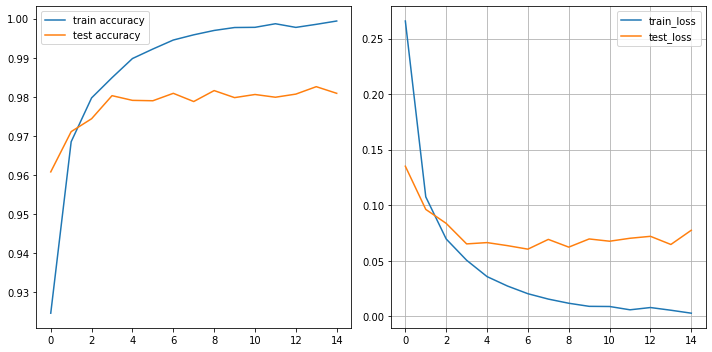

In [10]:
show_progress(history.history)

А теперь перейдем к загрузке модели. Если все реализовано правильно, то код ниже должен сработать без ошибок:

In [11]:
restored_model = tf.keras.models.load_model(cpt_path)
loss, acc = restored_model.evaluate(x_test, y_test)
print(f"Accuracy of restored model {acc*100 :.2f}%")
assert acc > 0.96

313/313 [==============================] - 1s 3ms/step - loss: 0.0648 - accuracy: 0.9826
Accuracy of restored model 98.26%


И, наконец, можно сравнить предсказания с реальными классами (с такой точностью найти ошибку будет сложно):

ValueError: ignored

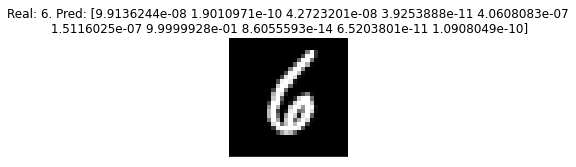

In [14]:
predicted_labels = restored_model.predict(x_test)
idxs = np.random.choice(np.arange(len(x_test)), 16, replace=False)
show_mnist(x_test[idxs].reshape((-1, 28, 28)), y_test[idxs], predicted_labels[idxs])